### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [6]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.12f}'.format
np.set_printoptions(precision=12)
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv("Cleaned1.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' , 'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'M0','Cus','Toe', 'Cic', 'OMEGA', 'e',
       'Cis', 'i0', 'omega', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx', 'Crs', 'Del_n', 'Cuc', 'Crc',
       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,sqrt_A
Epoch_Time_of_Clock,
2017-11-01 14:00:00,"5,153.670196530000"
2017-11-01 16:00:00,"5,153.669187550000"
2017-11-01 18:00:00,"5,153.669887540000"
2017-11-01 20:00:00,"5,153.670305250000"
2017-11-01 22:00:00,"5,153.673240660000"


In [8]:
df.columns

Index(['sqrt_A'], dtype='object')

# enter parameters and Satellite PRN

In [9]:
var_name = 'sqrt_A'
sat_var = 1

In [10]:
df = df.iloc[5 : , :]

In [11]:

df

,sqrt_A
Epoch_Time_of_Clock,
2017-11-02 12:00:00,"5,153.672128680000"
2017-11-02 14:00:00,"5,153.669368740000"
2017-11-02 16:00:00,"5,153.668636320000"
2017-11-02 18:00:00,"5,153.668607710000"
2017-11-02 20:00:00,"5,153.669593810000"
2017-11-02 22:00:00,"5,153.672065730000"
2017-11-03 12:00:00,"5,153.673458100000"
2017-11-03 14:00:00,"5,153.670349120000"
2017-11-03 16:00:00,"5,153.669727330000"


# Enter number of entries per day

In [12]:
entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))

168
2017-11-25 12:00:00 2017-11-21 12:00:00
<class 'str'>



Load data into Pandas dataframe

# enter lag and no. of outputs

In [13]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 6
HORIZON = 6

Create training set containing only the model features

In [16]:
train = df.copy()[df.index < valid_start_dt][['sqrt_A' ]]
train.head()

,sqrt_A
Epoch_Time_of_Clock,
2017-11-02 12:00:00,"5,153.672128680000"
2017-11-02 14:00:00,"5,153.669368740000"
2017-11-02 16:00:00,"5,153.668636320000"
2017-11-02 18:00:00,"5,153.668607710000"
2017-11-02 20:00:00,"5,153.669593810000"


In [17]:
train.tail(6)

,sqrt_A
Epoch_Time_of_Clock,
2017-11-20 12:00:00,"5,153.679801940000"
2017-11-20 14:00:00,"5,153.680685040000"
2017-11-20 16:00:00,"5,153.677953720000"
2017-11-20 18:00:00,"5,153.681100850000"
2017-11-20 20:00:00,"5,153.679851530000"
2017-11-20 22:00:00,"5,153.682205200000"


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [20]:
from sklearn.preprocessing import StandardScaler




y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()

train[[ 'sqrt_A' ]] = X_scaler.fit_transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [21]:
tensor_structure = {'X':(range(-T+1, 1), ['sqrt_A'])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), [ 'sqrt_A', ])} ,freq = None)

In [22]:
train_inputs.dataframe

tensor                       target                                  \
feature                           y                                   
time step                       t+1             t+2             t+3   
Epoch_Time_of_Clock                                                   
2017-11-02 22:00:00 -0.675754723574 -1.426387417839 -1.576512508022   
2017-11-03 12:00:00 -1.426387417839 -1.576512508022 -1.708220541186   
2017-11-03 14:00:00 -1.576512508022 -1.708220541186 -1.398295852747   
2017-11-03 16:00:00 -1.708220541186 -1.398295852747 -0.986138148336   
2017-11-03 18:00:00 -1.398295852747 -0.986138148336 -0.156759739101   
2017-11-03 20:00:00 -0.986138148336 -0.156759739101 -0.777987739546   
2017-11-03 22:00:00 -0.156759739101 -0.777987739546 -0.999953355422   
2017-11-04 12:00:00 -0.777987739546 -0.999953355422 -1.044163467163   
2017-11-04 14:00:00 -0.999953355422 -1.044163467163 -0.788579720265   
2017-11-04 16:00:00 -1.044163467163 -0.788579720265 -0.544049104567   
2017-11-04 18:00:00 -0.788579720265 -0.544049104567  0.409668583260   
2017-11-04 20:00:00 -0.544049104567  0.409668583260  0.106651498474   
2017-11-04 22:00:00  0.409668583260  0.106651498474 -0.297215150184   
2017-11-05 12:00:00  0.106651498474 -0.297215150184 -0.005251196818   
2017-11-05 14:00:00 -0.297215150184 -0.005251196818  0.068429103362   
2017-11-05 16:00:00 -0.005251196818  0.068429103362  0.259541078700   
2017-11-05 18:00:00  0.068429103362  0.259541078700  0.873863889868   
2017-11-05 20:00:00  0.259541078700  0.873863889868  0.972412528554   
2017-11-05 22:00:00  0.873863889868  0.972412528554  0.331381604613   
2017-11-06 12:00:00  0.972412528554  0.331381604613  1.056226072910   
2017-11-06 14:00:00  0.331381604613  1.056226072910  0.898729813998   
2017-11-06 16:00:00  1.056226072910  0.898729813998  1.184708465331   
2017-11-06 18:00:00  0.898729813998  1.184708465331  1.140039617486   
2017-11-06 20:00:00  1.184708465331  1.140039617486  1.594562830398   
2017-11-06 22:00:00  1.140039617486  1.594562830398  0.752289101100   
2017-11-07 12:00:00  1.594562830398  0.752289101100  1.762648655654   
2017-11-07 14:00:00  0.752289101100  1.762648655654  1.434304495819   
2017-11-07 16:00:00  1.762648655654  1.434304495819  1.900341990851   
2017-11-07 18:00:00  1.434304495819  1.900341990851  1.169512220301   
2017-11-07 20:00:00  1.900341990851  1.169512220301  1.838632294958   
...                             ...             ...             ...   
2017-11-15 12:00:00 -1.223763574538 -0.862262434602 -0.758645966530   
2017-11-15 14:00:00 -0.862262434602 -0.758645966530 -1.034952524167   
2017-11-15 16:00:00 -0.758645966530 -1.034952524167 -0.944231376158   
2017-11-15 18:00:00 -1.034952524167 -0.944231376158 -1.171264821641   
2017-11-15 20:00:00 -0.944231376158 -1.171264821641 -1.072716182955   
2017-11-15 22:00:00 -1.171264821641 -1.072716182955 -0.827263266077   
2017-11-16 12:00:00 -1.072716182955 -0.827263266077 -0.396224939570   
2017-11-16 14:00:00 -0.827263266077 -0.396224939570 -0.766937022283   
2017-11-16 16:00:00 -0.396224939570 -0.766937022283 -0.544968991810   
2017-11-16 18:00:00 -0.766937022283 -0.544968991810 -0.826802115377   
2017-11-16 20:00:00 -0.544968991810 -0.826802115377 -0.675293572874   
2017-11-16 22:00:00 -0.826802115377 -0.675293572874 -0.645820969839   
2017-11-17 12:00:00 -0.675293572874 -0.645820969839  0.049548481266   
2017-11-17 14:00:00 -0.645820969839  0.049548481266 -0.380106393141   
2017-11-17 16:00:00  0.049548481266 -0.380106393141  0.005340784121   
2017-11-17 18:00:00 -0.380106393141  0.005340784121 -0.311030357270   
2017-11-17 20:00:00  0.005340784121 -0.311030357270 -0.108406514189   
2017-11-17 22:00:00 -0.311030357270 -0.108406514189 -0.341425261705   
2017-11-18 12:00:00 -0.108406514189 -0.341425261705  0.501309618293   
2017-11-18 14:00:00 -0.341425261705  0.501309618293  0.062904952029   
2017-11-18 16:00:00  0.501309618293  0.062904952029  0.581438785582   
2017-11-18 18:00:00  0.0

In [23]:
train_inputs['target'].shape

(103, 6)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [24]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][[ 'sqrt_A']]
valid[['sqrt_A']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                      target                                \
feature                          y                                 
time step                      t+1            t+2            t+3   
Epoch_Time_of_Clock                                                
2017-11-21 22:00:00 1.575682208083 1.632785225290 0.964585037877   
2017-11-22 12:00:00 1.632785225290 0.964585037877 1.335294706214   
2017-11-22 14:00:00 0.964585037877 1.335294706214 1.321018348428   
2017-11-22 16:00:00 1.335294706214 1.321018348428 1.564629076663   
2017-11-22 18:00:00 1.321018348428 1.564629076663 1.600548132432   

tensor                                                            \
feature                                                            
time step                      t+4            t+5            t+6   
Epoch_Time_of_Clock                                                
2017-11-21 22:00:00 1.335294706214 1.321018348428 1.564629076663   
2017-11-22 12:00:00 1.321018348428 1.564629076663 1.600548132432   
2017-11-22 14:00:00 1.564629076663 1.600548132432 1.540683039558   
2017-11-22 16:00:00 1.600548132432 1.540683039558 1.040568677181   
2017-11-22 18:00:00 1.540683039558 1.040568677181 1.210957841780   

tensor                           X                                \
feature                     sqrt_A                                 
time step                      t-5            t-4            t-3   
Epoch_Time_of_Clock                                                
2017-11-21 22:00:00 1.308584179065 1.462396060692 0.736631705371   
2017-11-22 12:00:00 1.462396060692 0.736631705371 1.317795121842   
2017-11-22 14:00:00 0.736631705371 1.317795121842 1.150170447505   
2017-11-22 16:00:00 1.317795121842 1.150170447505 1.602390321075   
2017-11-22 18:00:00 1.150170447505 1.602390321075 1.575682208083   

tensor                                                            
feature                                                           
time step                      t-2            t-1              t  
Epoch_Time_of_Clock                                               
2017-11-21 22:00:00 1.317795121842 1.150170447505 1.602390321075  
2017-11-22 12:00:00 1.150170447505 1.602390321075 1.575682208083  
2017-11-22 14:00:00 1.602390321075 1.575682208083 1.632785225290  
2017-11-22 16:00:00 1.575682208083 1.632785225290 0.964585037877  
2017-11-22 18:00:00 1.632785225290 0.964585037877 1.335294706214

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [25]:
#Image('./images/simple_encoder_decoder.png')

In [41]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [42]:
LATENT_DIM = 64
BATCH_SIZE = 32
EPOCHS = 1000

In [43]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,1 ) , return_sequences = True))
model.add(LSTM(LATENT_DIM))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [44]:
model.compile(optimizer='RMSprop', loss='mse')

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 6, 64)             16896     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                33024     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 6, 64)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 6, 64)             33024     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 6, 1)              65        
_________________________________________________________________
flatten_3 (Flatten)          (None, 6)                 0         
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________


In [46]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [47]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [48]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 103 samples, validate on 13 samples
Epoch 1/1000
103/103 [==============================] - 2s 20ms/step - loss: 0.8441 - val_loss: 0.8807
Epoch 2/1000
103/103 [==============================] - 0s 640us/step - loss: 0.5612 - val_loss: 0.3280
Epoch 3/1000
103/103 [==============================] - 0s 810us/step - loss: 0.6011 - val_loss: 0.3302
Epoch 4/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.4688 - val_loss: 0.2944
Epoch 5/1000
103/103 [==============================] - 0s 783us/step - loss: 0.4669 - val_loss: 0.2817
Epoch 6/1000
103/103 [==============================] - 0s 995us/step - loss: 0.4588 - val_loss: 0.2704
Epoch 7/1000
103/103 [==============================] - 0s 902us/step - loss: 0.4504 - val_loss: 0.2591
Epoch 8/1000
103/103 [==============================] - 0s 960us/step - loss: 0.4428 - val_loss: 0.2480
Epoch 9/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.4358 - val_loss: 0.2370
Epoch 10/1000
103/103 [=

103/103 [==============================] - 0s 708us/step - loss: 0.1985 - val_loss: 0.0588
Epoch 80/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.2019 - val_loss: 0.0698
Epoch 81/1000
103/103 [==============================] - 0s 897us/step - loss: 0.2058 - val_loss: 0.1319
Epoch 82/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.2034 - val_loss: 0.1515
Epoch 83/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1982 - val_loss: 0.1419
Epoch 84/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1951 - val_loss: 0.1340
Epoch 85/1000
103/103 [==============================] - 0s 956us/step - loss: 0.1935 - val_loss: 0.1265
Epoch 86/1000
103/103 [==============================] - 0s 943us/step - loss: 0.1923 - val_loss: 0.1178
Epoch 87/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1911 - val_loss: 0.1078
Epoch 88/1000
103/103 [==============================] - 0s 958us/step - loss: 

103/103 [==============================] - 0s 1ms/step - loss: 0.1687 - val_loss: 0.0849
Epoch 158/1000
103/103 [==============================] - 0s 885us/step - loss: 0.1692 - val_loss: 0.1033
Epoch 159/1000
103/103 [==============================] - 0s 754us/step - loss: 0.1681 - val_loss: 0.0846
Epoch 160/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1687 - val_loss: 0.1049
Epoch 161/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1674 - val_loss: 0.0846
Epoch 162/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1682 - val_loss: 0.1073
Epoch 163/1000
103/103 [==============================] - 0s 890us/step - loss: 0.1669 - val_loss: 0.0847
Epoch 164/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1675 - val_loss: 0.1092
Epoch 165/1000
103/103 [==============================] - 0s 956us/step - loss: 0.1661 - val_loss: 0.0848
Epoch 166/1000
103/103 [==============================] - 0s 1ms/step -

103/103 [==============================] - 0s 1ms/step - loss: 0.1462 - val_loss: 0.0723
Epoch 236/1000
103/103 [==============================] - 0s 691us/step - loss: 0.1467 - val_loss: 0.1496
Epoch 237/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1468 - val_loss: 0.0532
Epoch 238/1000
103/103 [==============================] - 0s 762us/step - loss: 0.1512 - val_loss: 0.1688
Epoch 239/1000
103/103 [==============================] - 0s 986us/step - loss: 0.1468 - val_loss: 0.0738
Epoch 240/1000
103/103 [==============================] - 0s 886us/step - loss: 0.1460 - val_loss: 0.1274
Epoch 241/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1435 - val_loss: 0.0705
Epoch 242/1000
103/103 [==============================] - 0s 940us/step - loss: 0.1449 - val_loss: 0.1299
Epoch 243/1000
103/103 [==============================] - 0s 840us/step - loss: 0.1430 - val_loss: 0.0596
Epoch 244/1000
103/103 [==============================] - 0s 1ms/st

103/103 [==============================] - 0s 716us/step - loss: 0.1165 - val_loss: 0.0516
Epoch 314/1000
103/103 [==============================] - 0s 746us/step - loss: 0.1165 - val_loss: 0.0794
Epoch 315/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1237 - val_loss: 0.0373
Epoch 316/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1341 - val_loss: 0.2309
Epoch 317/1000
103/103 [==============================] - 0s 915us/step - loss: 0.1370 - val_loss: 0.1820
Epoch 318/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1230 - val_loss: 0.1252
Epoch 319/1000
103/103 [==============================] - 0s 966us/step - loss: 0.1165 - val_loss: 0.1332
Epoch 320/1000
103/103 [==============================] - 0s 923us/step - loss: 0.1152 - val_loss: 0.0948
Epoch 321/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1138 - val_loss: 0.0684
Epoch 322/1000
103/103 [==============================] - 0s 938us/st

103/103 [==============================] - 0s 1ms/step - loss: 0.1037 - val_loss: 0.1771
Epoch 392/1000
103/103 [==============================] - 0s 977us/step - loss: 0.1056 - val_loss: 0.0381
Epoch 393/1000
103/103 [==============================] - 0s 984us/step - loss: 0.1071 - val_loss: 0.1314
Epoch 394/1000
103/103 [==============================] - 0s 964us/step - loss: 0.0981 - val_loss: 0.0426
Epoch 395/1000
103/103 [==============================] - 0s 720us/step - loss: 0.1003 - val_loss: 0.1001
Epoch 396/1000
103/103 [==============================] - 0s 811us/step - loss: 0.0951 - val_loss: 0.0384
Epoch 397/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1010 - val_loss: 0.1631
Epoch 398/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0988 - val_loss: 0.0723
Epoch 399/1000
103/103 [==============================] - 0s 940us/step - loss: 0.1022 - val_loss: 0.2404
Epoch 400/1000
103/103 [==============================] - 0s 947us/

103/103 [==============================] - 0s 1ms/step - loss: 0.0782 - val_loss: 0.0623
Epoch 470/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0782 - val_loss: 0.0533
Epoch 471/1000
103/103 [==============================] - 0s 832us/step - loss: 0.0788 - val_loss: 0.0697
Epoch 472/1000
103/103 [==============================] - 0s 876us/step - loss: 0.0809 - val_loss: 0.0497
Epoch 473/1000
103/103 [==============================] - 0s 906us/step - loss: 0.0890 - val_loss: 0.2341
Epoch 474/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1273 - val_loss: 0.1630
Epoch 475/1000
103/103 [==============================] - 0s 816us/step - loss: 0.0887 - val_loss: 0.0461
Epoch 476/1000
103/103 [==============================] - 0s 742us/step - loss: 0.0811 - val_loss: 0.0925
Epoch 477/1000
103/103 [==============================] - 0s 833us/step - loss: 0.0779 - val_loss: 0.0477
Epoch 478/1000
103/103 [==============================] - 0s 826us/

103/103 [==============================] - 0s 445us/step - loss: 0.0743 - val_loss: 0.0792
Epoch 548/1000
103/103 [==============================] - 0s 441us/step - loss: 0.0617 - val_loss: 0.0708
Epoch 549/1000
103/103 [==============================] - 0s 461us/step - loss: 0.0599 - val_loss: 0.0909
Epoch 550/1000
103/103 [==============================] - 0s 482us/step - loss: 0.0582 - val_loss: 0.0640
Epoch 551/1000
103/103 [==============================] - 0s 490us/step - loss: 0.0592 - val_loss: 0.1489
Epoch 552/1000
103/103 [==============================] - 0s 455us/step - loss: 0.0692 - val_loss: 0.0586
Epoch 553/1000
103/103 [==============================] - 0s 458us/step - loss: 0.0696 - val_loss: 0.1745
Epoch 554/1000
103/103 [==============================] - 0s 449us/step - loss: 0.0629 - val_loss: 0.0501
Epoch 555/1000
103/103 [==============================] - 0s 449us/step - loss: 0.0668 - val_loss: 0.1443
Epoch 556/1000
103/103 [==============================] - 0s 

103/103 [==============================] - 0s 438us/step - loss: 0.0691 - val_loss: 0.1409
Epoch 625/1000
103/103 [==============================] - 0s 430us/step - loss: 0.0552 - val_loss: 0.1191
Epoch 626/1000
103/103 [==============================] - 0s 438us/step - loss: 0.0585 - val_loss: 0.0913
Epoch 627/1000
103/103 [==============================] - 0s 420us/step - loss: 0.0448 - val_loss: 0.0577
Epoch 628/1000
103/103 [==============================] - 0s 427us/step - loss: 0.0418 - val_loss: 0.0701
Epoch 629/1000
103/103 [==============================] - 0s 412us/step - loss: 0.0413 - val_loss: 0.0602
Epoch 630/1000
103/103 [==============================] - 0s 410us/step - loss: 0.0432 - val_loss: 0.0843
Epoch 631/1000
103/103 [==============================] - 0s 431us/step - loss: 0.0473 - val_loss: 0.0576
Epoch 632/1000
103/103 [==============================] - 0s 416us/step - loss: 0.0621 - val_loss: 0.1243
Epoch 633/1000
103/103 [==============================] - 0s 

103/103 [==============================] - 0s 481us/step - loss: 0.0327 - val_loss: 0.0838
Epoch 702/1000
103/103 [==============================] - 0s 582us/step - loss: 0.0337 - val_loss: 0.1011
Epoch 703/1000
103/103 [==============================] - 0s 435us/step - loss: 0.0341 - val_loss: 0.0677
Epoch 704/1000
103/103 [==============================] - 0s 424us/step - loss: 0.0344 - val_loss: 0.0889
Epoch 705/1000
103/103 [==============================] - 0s 417us/step - loss: 0.0360 - val_loss: 0.0537
Epoch 706/1000
103/103 [==============================] - 0s 434us/step - loss: 0.0370 - val_loss: 0.1757
Epoch 707/1000
103/103 [==============================] - 0s 454us/step - loss: 0.0403 - val_loss: 0.0636
Epoch 708/1000
103/103 [==============================] - 0s 413us/step - loss: 0.0372 - val_loss: 0.1344
Epoch 709/1000
103/103 [==============================] - 0s 427us/step - loss: 0.0381 - val_loss: 0.0822
Epoch 710/1000
103/103 [==============================] - 0s 

103/103 [==============================] - 0s 430us/step - loss: 0.0341 - val_loss: 0.0916
Epoch 779/1000
103/103 [==============================] - 0s 417us/step - loss: 0.0632 - val_loss: 0.1021
Epoch 780/1000
103/103 [==============================] - 0s 420us/step - loss: 0.0492 - val_loss: 0.0863
Epoch 781/1000
103/103 [==============================] - 0s 417us/step - loss: 0.0306 - val_loss: 0.0909
Epoch 782/1000
103/103 [==============================] - 0s 609us/step - loss: 0.0262 - val_loss: 0.0990
Epoch 783/1000
103/103 [==============================] - 0s 644us/step - loss: 0.0240 - val_loss: 0.1049
Epoch 784/1000
103/103 [==============================] - 0s 435us/step - loss: 0.0228 - val_loss: 0.0939
Epoch 785/1000
103/103 [==============================] - 0s 439us/step - loss: 0.0235 - val_loss: 0.0998
Epoch 786/1000
103/103 [==============================] - 0s 576us/step - loss: 0.0258 - val_loss: 0.1139
Epoch 787/1000
103/103 [==============================] - 0s 

103/103 [==============================] - 0s 420us/step - loss: 0.0456 - val_loss: 0.1016
Epoch 856/1000
103/103 [==============================] - 0s 424us/step - loss: 0.0267 - val_loss: 0.0849
Epoch 857/1000
103/103 [==============================] - 0s 426us/step - loss: 0.0187 - val_loss: 0.1146
Epoch 858/1000
103/103 [==============================] - 0s 432us/step - loss: 0.0174 - val_loss: 0.0980
Epoch 859/1000
103/103 [==============================] - 0s 411us/step - loss: 0.0167 - val_loss: 0.1174
Epoch 860/1000
103/103 [==============================] - 0s 424us/step - loss: 0.0178 - val_loss: 0.0841
Epoch 861/1000
103/103 [==============================] - 0s 424us/step - loss: 0.0198 - val_loss: 0.1059
Epoch 862/1000
103/103 [==============================] - 0s 424us/step - loss: 0.0199 - val_loss: 0.1066
Epoch 863/1000
103/103 [==============================] - 0s 432us/step - loss: 0.0275 - val_loss: 0.1927
Epoch 864/1000
103/103 [==============================] - 0s 

In [ ]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

In [ ]:
 model.fit(valid_inputs['X'],
          valid_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=100,
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

## Evaluate the model

In [34]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = df.copy()[test_start_dt:][['sqrt_A',]]
test[[ 'sqrt_A']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                      target                                 \
feature                          y                                  
time step                      t+1            t+2             t+3   
Epoch_Time_of_Clock                                                 
2017-11-25 22:00:00 0.329539415970 0.018233689588  0.201057023550   
2017-11-26 12:00:00 0.018233689588 0.201057023550  0.145796194985   
2017-11-26 14:00:00 0.201057023550 0.145796194985  0.744459196048   
2017-11-26 16:00:00 0.145796194985 0.744459196048  0.112178064184   
2017-11-26 18:00:00 0.744459196048 0.112178064184 -0.327148903700   

tensor                                                               \
feature                                                               
time step                       t+4             t+5             t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00  0.145796194985  0.744459196048  0.112178064184   
2017-11-26 12:00:00  0.744459196048  0.112178064184 -0.327148903700   
2017-11-26 14:00:00  0.112178064184 -0.327148903700 -0.628321385686   
2017-11-26 16:00:00 -0.327148903700 -0.628321385686 -0.366752336535   
2017-11-26 18:00:00 -0.628321385686 -0.366752336535 -0.332675469409   

tensor                           X                                \
feature                     sqrt_A                                 
time step                      t-5            t-4            t-3   
Epoch_Time_of_Clock                                                
2017-11-25 22:00:00 0.931886794099 0.666633367882 0.654660349438   
2017-11-26 12:00:00 0.666633367882 0.654660349438 0.593411804245   
2017-11-26 14:00:00 0.654660349438 0.593411804245 1.071883468639   
2017-11-26 16:00:00 0.593411804245 1.071883468639 0.549662843424   
2017-11-26 18:00:00 1.071883468639 0.549662843424 0.329539415970   

tensor                                                            
feature                                                           
time step                      t-2            t-1              t  
Epoch_Time_of_Clock                                               
2017-11-25 22:00:00 0.593411804245 1.071883468639 0.549662843424  
2017-11-26 12:00:00 1.071883468639 0.549662843424 0.329539415970  
2017-11-26 14:00:00 0.549662843424 0.329539415970 0.018233689588  
2017-11-26 16:00:00 0.329539415970 0.018233689588 0.201057023550  
2017-11-26 18:00:00 0.018233689588 0.201057023550 0.145796194985

In [35]:
test_inputs.dataframe.head(50)

tensor                       target                                  \
feature                           y                                   
time step                       t+1             t+2             t+3   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00  0.329539415970  0.018233689588  0.201057023550   
2017-11-26 12:00:00  0.018233689588  0.201057023550  0.145796194985   
2017-11-26 14:00:00  0.201057023550  0.145796194985  0.744459196048   
2017-11-26 16:00:00  0.145796194985  0.744459196048  0.112178064184   
2017-11-26 18:00:00  0.744459196048  0.112178064184 -0.327148903700   
2017-11-26 20:00:00  0.112178064184 -0.327148903700 -0.628321385686   
2017-11-26 22:00:00 -0.327148903700 -0.628321385686 -0.366752336535   
2017-11-27 12:00:00 -0.628321385686 -0.366752336535 -0.332675469409   
2017-11-27 14:00:00 -0.366752336535 -0.332675469409  0.327697227327   
2017-11-27 16:00:00 -0.332675469409  0.327697227327 -0.242415472100   
2017-11-27 18:00:00  0.327697227327 -0.242415472100 -0.903708056080   
2017-11-27 20:00:00 -0.242415472100 -0.903708056080 -1.147318784535   
2017-11-27 22:00:00 -0.903708056080 -1.147318784535 -0.947457016901   
2017-11-28 12:00:00 -1.147318784535 -0.947457016901 -0.764172532240   
2017-11-28 14:00:00 -0.947457016901 -0.764172532240 -0.113933079899   
2017-11-28 16:00:00 -0.764172532240 -0.113933079899 -0.424777655362   
2017-11-28 18:00:00 -0.113933079899 -0.424777655362 -1.241721895234   
2017-11-28 20:00:00 -0.424777655362 -1.241721895234 -1.410268871190   
2017-11-28 22:00:00 -1.241721895234 -1.410268871190 -1.375730853365   

tensor                                                               \
feature                                                               
time step                       t+4             t+5             t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00  0.145796194985  0.744459196048  0.112178064184   
2017-11-26 12:00:00  0.744459196048  0.112178064184 -0.327148903700   
2017-11-26 14:00:00  0.112178064184 -0.327148903700 -0.628321385686   
2017-11-26 16:00:00 -0.327148903700 -0.628321385686 -0.366752336535   
2017-11-26 18:00:00 -0.628321385686 -0.366752336535 -0.332675469409   
2017-11-26 20:00:00 -0.366752336535 -0.332675469409  0.327697227327   
2017-11-26 22:00:00 -0.332675469409  0.327697227327 -0.242415472100   
2017-11-27 12:00:00  0.327697227327 -0.242415472100 -0.903708056080   
2017-11-27 14:00:00 -0.242415472100 -0.903708056080 -1.147318784535   
2017-11-27 16:00:00 -0.903708056080 -1.147318784535 -0.947457016901   
2017-11-27 18:00:00 -1.147318784535 -0.947457016901 -0.764172532240   
2017-11-27 20:00:00 -0.947457016901 -0.764172532240 -0.113933079899   
2017-11-27 22:00:00 -0.764172532240 -0.113933079899 -0.424777655362   
2017-11-28 12:00:00 -0.113933079899 -0.424777655362 -1.241721895234   
2017-11-28 14:00:00 -0.424777655362 -1.241721895234 -1.410268871190   
2017-11-28 16:00:00 -1.241721895234 -1.410268871190 -1.375730853365   
2017-11-28 18:00:00 -1.410268871190 -1.375730853365 -1.031268147101   
2017-11-28 20:00:00 -1.375730853365 -1.031268147101 -0.481419521869   
2017-11-28 22:00:00 -1.031268147101 -0.481419521869 -0.379647656817   

tensor                            X                                  \
feature                      sqrt_A                                   
time step                       t-5             t-4             t-3   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00  0.931886794099  0.666633367882  0.654660349438   
2017-11-26 12:00:00  0.666633367882  0.654660349438  0.593411804245   
2017-11-26 14:00:00  0.654660349438  0.593411804245  1.071883468639   
2017-11-26 16:00:00  0.593411804245  1.071883468639  0.549662843424   
2017-11-26 18:00:00  1.071883468639  0.549662843424  0.329539415970   
2017-11-26 20:00:00  0.549662843424  0.329539415970  0.018233689588   
2017-11-26 22:00:00  0

In [49]:
test_inputs.dataframe.shape

(19, 12)

In [50]:
predictions = model.predict(test_inputs['X'])

In [51]:
predictions

array([[ 0.6917563   ,  0.24262266  ,  0.22719222  ,  0.28696585  ,
         0.4290662   ,  0.39893463  ],
       [ 0.3483508   , -0.036233913 , -0.05260812  , -0.18223044  ,
        -0.06523806  , -0.29652646  ],
       [-0.15085994  , -0.16838273  ,  0.09653863  , -0.15122715  ,
        -0.095460564 , -0.40536705  ],
       [-0.25189507  ,  0.10488853  , -0.19355524  , -0.21186623  ,
        -0.3963569   , -0.44327196  ],
       [ 0.39475784  , -0.0036518835, -0.10132682  , -0.20630407  ,
        -0.3344156   , -0.45097885  ],
       [ 0.70721686  ,  0.77805245  ,  0.518649    ,  0.9282283   ,
         0.59483635  ,  1.0405345   ],
       [ 0.96074355  ,  0.41442063  ,  0.55076885  ,  0.4809657   ,
         0.9446499   ,  0.80569404  ],
       [ 0.5068792   ,  0.49169174  ,  0.90519255  ,  0.54049754  ,
         0.8726349   ,  0.50837064  ],
       [-1.0098432   , -0.48989135  , -0.665987    , -0.8365729   ,
        -0.9079364   , -0.9869681   ],
       [-1.3051845   , -0.5128123   ,

In [52]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h         prediction             actual
0 2017-11-25 22:00:00  t+1 5,153.679122074512 5,153.677621840000
1 2017-11-26 12:00:00  t+1 5,153.677699753201 5,153.676332470000
2 2017-11-26 14:00:00  t+1 5,153.675632115875 5,153.677089690000
3 2017-11-26 16:00:00  t+1 5,153.675213647281 5,153.676860810000
4 2017-11-26 18:00:00  t+1 5,153.677891962482 5,153.679340360000
              timestamp    h         prediction             actual
109 2017-11-28 14:00:00  t+6 5,153.671326949908 5,153.670415880000
110 2017-11-28 16:00:00  t+6 5,153.670566086720 5,153.670558930000
111 2017-11-28 18:00:00  t+6 5,153.674216258086 5,153.671985630000
112 2017-11-28 20:00:00  t+6 5,153.676476962462 5,153.674263000000
113 2017-11-28 22:00:00  t+6 5,153.677394256172 5,153.674684520000
(114, 4)


In [53]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   0.000000567804
t+2   0.000000558260
t+3   0.000000636456
t+4   0.000000539660
t+5   0.000000430203
t+6   0.000000425914
Name: APE, dtype: float64

# prediction result

In [54]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

0.002712806543018942

In [55]:
eval_df['prediction']

0     5,153.679122074512
1     5,153.677699753201
2     5,153.675632115875
3     5,153.675213647281
4     5,153.677891962482
5     5,153.679186109217
6     5,153.680236169263
7     5,153.678356348207
8     5,153.672074367992
9     5,153.670851119849
10    5,153.677476877445
11    5,153.680717626999
12    5,153.676598766203
13    5,153.675706940336
14    5,153.670411884998
15    5,153.669325091001
16    5,153.677301489847
17    5,153.679101375590
18    5,153.674403843963
19    5,153.677261847073
20    5,153.676106875393
21    5,153.675559539733
22    5,153.676691378109
23    5,153.676241824056
24    5,153.679479496962
25    5,153.677973402106
26    5,153.678293444543
27    5,153.674227911274
28    5,153.674132976926
29    5,153.675812879773
             ...        
84    5,153.672496447016
85    5,153.672175385494
86    5,153.674473287864
87    5,153.679782620817
88    5,153.677181652361
89    5,153.678206419209
90    5,153.670919343712
91    5,153.670772086973
92    5,153.674440933162


Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

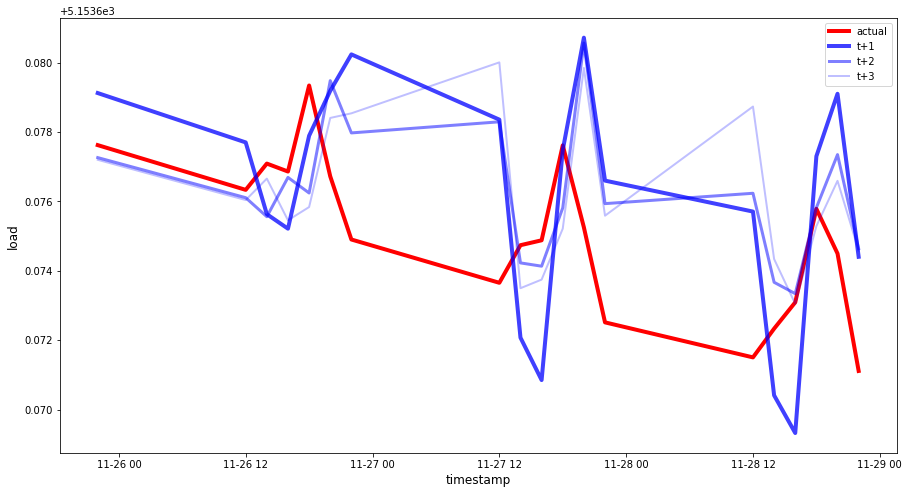

In [56]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [57]:
a = df.iloc[156:162  , :]
a

,sqrt_A
Epoch_Time_of_Clock,
2017-11-28 12:00:00,"5,153.672513960000"
2017-11-28 14:00:00,"5,153.671504970000"
2017-11-28 16:00:00,"5,153.672332760000"
2017-11-28 18:00:00,"5,153.673091890000"
2017-11-28 20:00:00,"5,153.675785060000"
2017-11-28 22:00:00,"5,153.674497600000"


In [58]:
new_df = pd.DataFrame()

In [59]:
columns = ['sqrt_A'] 

In [60]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [61]:
new_df = new_df.dropna( how = 'any')

In [62]:
new_df

,sqrt_A
Epoch_Time_of_Clock,
2017-11-28 12:00:00,"5,153.672513960000"
2017-11-28 14:00:00,"5,153.671504970000"
2017-11-28 16:00:00,"5,153.672332760000"
2017-11-28 18:00:00,"5,153.673091890000"
2017-11-28 20:00:00,"5,153.675785060000"
2017-11-28 22:00:00,"5,153.674497600000"


In [63]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 29)

In [64]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [65]:
date

DatetimeIndex(['2017-11-29 12:00:00', '2017-11-29 14:00:00',
               '2017-11-29 16:00:00', '2017-11-29 18:00:00',
               '2017-11-29 20:00:00', '2017-11-29 22:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='2H')

In [66]:
new_df.index= date

In [67]:
new_df.columns

Index(['sqrt_A'], dtype='object')

In [68]:
print(new_df)
print(new_df.columns)

                                sqrt_A
Epoch_Time_of_Clock                   
2017-11-29 12:00:00 5,153.672513960000
2017-11-29 14:00:00 5,153.671504970000
2017-11-29 16:00:00 5,153.672332760000
2017-11-29 18:00:00 5,153.673091890000
2017-11-29 20:00:00 5,153.675785060000
2017-11-29 22:00:00 5,153.674497600000
Index(['sqrt_A'], dtype='object')


In [69]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[['sqrt_A']] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), [ 'sqrt_A'])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                             sqrt_A
Epoch_Time_of_Clock                
2017-11-29 12:00:00 -0.903708056080
2017-11-29 14:00:00 -1.147318784535
2017-11-29 16:00:00 -0.947457016901
2017-11-29 18:00:00 -0.764172532240
2017-11-29 20:00:00 -0.113933079899


In [70]:
print(new_new_df)
print(inputs['X'])

tensor                            X                                  \
feature                      sqrt_A                                   
time step                       t-5             t-4             t-3   
Epoch_Time_of_Clock                                                   
2017-11-29 22:00:00 -0.903708056080 -1.147318784535 -0.947457016901   

tensor                                                               
feature                                                              
time step                       t-2             t-1               t  
Epoch_Time_of_Clock                                                  
2017-11-29 22:00:00 -0.764172532240 -0.113933079899 -0.424777655362  
[[[-0.90370805608 ]
  [-1.147318784535]
  [-0.947457016901]
  [-0.76417253224 ]
  [-0.113933079899]
  [-0.424777655362]]]


In [71]:
predictions = model.predict(inputs['X'])

In [72]:
predictions

array([[-0.44741413 , -0.39113715 , -0.40431628 , -0.120824456,
         0.37140098 ,  0.27459154 ]], dtype=float32)

In [73]:
print(predictions.shape)


(1, 6)


In [74]:
results = predictions[-1, :]

In [75]:
results

array([-0.44741413 , -0.39113715 , -0.40431628 , -0.120824456,
        0.37140098 ,  0.27459154 ], dtype=float32)

In [76]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,sqrt_A
0,-0.447414129972
1,-0.391137152910
2,-0.404316276312
3,-0.120824456215
4,0.371400982141
5,0.274591535330


In [77]:
res_df.index = date
res_df

,sqrt_A
Epoch_Time_of_Clock,
2017-11-29 12:00:00,-0.447414129972
2017-11-29 14:00:00,-0.391137152910
2017-11-29 16:00:00,-0.404316276312
2017-11-29 18:00:00,-0.120824456215
2017-11-29 20:00:00,0.371400982141
2017-11-29 22:00:00,0.274591535330


In [78]:
res_df[[var_name]]

,sqrt_A
Epoch_Time_of_Clock,
2017-11-29 12:00:00,-0.447414129972
2017-11-29 14:00:00,-0.391137152910
2017-11-29 16:00:00,-0.404316276312
2017-11-29 18:00:00,-0.120824456215
2017-11-29 20:00:00,0.371400982141
2017-11-29 22:00:00,0.274591535330


In [79]:
res_df[[var_name]] = y_scalar.inverse_transform(res_df[[var_name]]) 

In [80]:
#res_df[[var_name]] = y_scalar.inverse_transform(res_df[[var_name]]) 
#pd.set_option("display.precision", 8)
#a = pd.Series( dtype = float)
#list_b = []

#for i in range(res_df.shape[0]):
#    list_b.append( "%.20f"%res_df.iloc[i ,0])
    

#print(list_b)
#for i in range(res_df.shape[0]):
#    res_df.iloc[i , 1] = y_scalar.inverse_transform(np.array(res_df.iloc[i ,0]).reshape(1,-1))[0]
#    c[0 , j] = y_scalar.inverse_transform(np.array(res_df.iloc[i ,0]).reshape(1,-1))[0]
#    j +=1





#print (y_scalar.inverse_transform(np.array(list_b).reshape(-1,1)))    


#print (y_scalar.inverse_transform(list_b))    
#a['prediction']
#res_df['inverted'] = 0
#c = np.array()
#a
#j=0

#for i in range(res_df.shape[0]):
    #res_df.iloc[i , 1] = y_scalar.inverse_transform(np.array(res_df.iloc[i ,0]).reshape(1,-1))[0]
    #c[0 , j] = y_scalar.inverse_transform(np.array(res_df.iloc[i ,0]).reshape(1,-1))[0]
    #j +=1

#b = np.array(-1.08850443363189697266).reshape(1,-1)

#y_scalar.inverse_transform(b)

# final generated output 

In [81]:
# final generated ouput
res_df

,sqrt_A
Epoch_Time_of_Clock,
2017-11-29 12:00:00,"5,153.674316406250"
2017-11-29 14:00:00,"5,153.674804687500"
2017-11-29 16:00:00,"5,153.674804687500"
2017-11-29 18:00:00,"5,153.675781250000"
2017-11-29 20:00:00,"5,153.677734375000"
2017-11-29 22:00:00,"5,153.677246093750"


In [82]:
res_df.to_csv('SA1SqrtAWithoutC.csv')

In [83]:
df.tail(6)

,sqrt_A
Epoch_Time_of_Clock,
2017-11-29 12:00:00,"5,153.671113970000"
2017-11-29 14:00:00,"5,153.670415880000"
2017-11-29 16:00:00,"5,153.670558930000"
2017-11-29 18:00:00,"5,153.671985630000"
2017-11-29 20:00:00,"5,153.674263000000"
2017-11-29 22:00:00,"5,153.674684520000"
